In [1]:
import os

QM9_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/filtered_QM9_charges_radicals_stereo.smi"
# ChEMBL_CNOF_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/filtered_ChEMBL_charges_radicals_stereo_CNOF.smi"
json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/cache_QM9.json"


output_fig_path = os.environ["FIGURES"] + "/07_BBO/02_models/these/HOMO/"
output_data_path = os.environ["DATA"] + "/07_BBO/02_models/these/HOMO/03.02_HOMO_prediction_no_shuffle/"

N_JOBS = 10

dft_path = "/tmp"
os.makedirs(output_fig_path, exist_ok=True)
os.makedirs(output_data_path, exist_ok=True)

In [2]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct

kernels = [
    ("RBF", 1.0*RBF(1.0)),
    ("DotProduct", 1.0*DotProduct(1.0))
]

In [3]:
import csv
from evomol.evaluation import QEDEvaluationStrategy
from evomol.evaluation_dft import OPTEvaluationStrategy
import numpy as np

def load_smiles_dataset(path):
    
    all_smiles = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in reader:
            all_smiles.append(row[0])
            
#     np.random.shuffle(all_smiles)
    return all_smiles
        

def compute_QED(dataset_smiles):
    
    s = QEDEvaluationStrategy()
    return [s.eval_smi(smi) for smi in dataset_smiles]

In [4]:
QM9_smiles = load_smiles_dataset(QM9_path)
# ChEMBL_smiles = load_smiles_dataset(ChEMBL_CNOF_path)

print(len(QM9_smiles))
# print(len(ChEMBL_smiles))

132040


In [5]:
import numpy as np

def gen_splits(size, n_splits):
    
    for i in range(n_splits):
        
        train_idx = np.arange(i*size, i*size + size)
        test_idx = np.array(np.setdiff1d(np.arange(n_splits*size), train_idx))
        yield train_idx, test_idx
        

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from chemdesc.descriptors import ShinglesVectDesc, MBTRDesc
from tqdm import tqdm
import time
from sklearn.model_selection import cross_validate


def procedure(complete_smiles_list, kernels, alpha_values, test_on=None):
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                       working_dir_path=dft_path, MM_program="rdkit")
    
    
    output_dict = {}
    
    smiles_list = complete_smiles_list[:100000]
    
#     smiles_list = complete_smiles_list[:100]
   


    X_shingles = desc_builder_shingles.fit_transform(smiles_list)[0]
    X_mbtr = desc_builder_mbtr.fit_transform(smiles_list)[0]
    y = np.array([eval_strat.eval_smi(smi) for smi in smiles_list])
    
    for kernel_tuple in kernels:
        
        if kernel_tuple[0] == "RBF":
            X = X_mbtr
        elif kernel_tuple[0] == "DotProduct":
            X = X_shingles
        else:
            print("neither")
    
        
        output_dict[kernel_tuple[0]] = {alpha: {} for alpha in alpha_values}
        
        
        for alpha_value in alpha_values:
            
            generator = gen_splits(1000, 100)
        
#             generator = gen_splits(10, 10)
        
            kernel = kernel_tuple[1]
            model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, alpha=alpha_value)

            results = cross_validate(model, X, y, scoring="neg_mean_absolute_error", cv=generator, n_jobs=N_JOBS)
            
            output_dict[kernel_tuple[0]][alpha_value]["scores"] = list(results["test_score"])
            output_dict[kernel_tuple[0]][alpha_value]["fit_times"] = list(results["fit_time"])
            output_dict[kernel_tuple[0]][alpha_value]["score_times"] = list(results["score_time"])
        
    
            
    return output_dict



In [8]:
results_learning = procedure(QM9_smiles, kernels, alpha_values=[1e0, 1e-1, 1e-2, 1e-3])

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


  0%|          | 19/100000 [00:00<08:48, 189.15it/s]

DFT MM rdkit
133798 molecules in cache


  6%|▌         | 5913/100000 [00:12<03:48, 411.92it/s]

KeyboardInterrupt: 

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
    


In [10]:
import json
from os.path import join

# with open(join(output_data_path, "results_no_shuffle.json"), "w") as f:
#     json.dump(results_learning, f)


In [11]:
import json
from os.path import join

with open(join(output_data_path, "results_no_shuffle.json"), "r") as f:
    results_dict = json.load(f)
    

In [12]:
results_dict

{'RBF': {'1.0': {'scores': [-0.345838999648779,
    -0.5362300083978143,
    -0.5141091880803517,
    -0.4425624166944647,
    -0.5485348360339131,
    -0.3692101305679551,
    -0.5034170394931138,
    -0.4670500763402145,
    -0.38959437510271,
    -0.5890642276075728,
    -0.5106959933749208,
    -0.4650643807195793,
    -0.4462595063737597,
    -0.453461534481499,
    -0.4724736597429193,
    -0.4759543059633765,
    -0.4423648432075926,
    -0.4513652119551444,
    -0.4479215599930134,
    -0.4493609274167755,
    -0.40593022589797084,
    -0.36830385134330057,
    -0.4531473846832432,
    -0.4552574323111586,
    -0.7562451737460071,
    -0.6744058178583892,
    -0.9459068428292637,
    -1.0296114102830836,
    -0.9883984464784055,
    -0.950315362704377,
    -0.7177877294440059,
    -0.7661256430718206,
    -0.6427067413124911,
    -0.4916644462248709,
    -0.3527302142305075,
    -0.3777420778315295,
    -0.3534286971381832,
    -0.5345577785902613,
    -0.4917275211942526,
    

In [13]:
def plot_results(results_dict, alpha_values):
    
    for alpha_value in alpha_values:
        
        print(alpha_value)
        for kernel in ["RBF", "DotProduct"]:
            print(kernel)
            data = -np.array(results_dict[kernel][str(alpha_value)]["scores"])
            print("Moyenne : " + str(np.mean(data)))
            print("Médiane : " + str(np.median(data)))
            print("Stddev : " + str(np.std(data)))
        
        print()


In [14]:
plot_results(results_dict, [1e0, 1e-1, 1e-2, 1e-3])

1.0
RBF
Moyenne : 0.4965868098155937
Médiane : 0.46442394815550236
Stddev : 0.12150973577191493
DotProduct
Moyenne : 0.4183846280343375
Médiane : 0.3744928082628439
Stddev : 0.14866999563644845

0.1
RBF
Moyenne : 0.40842261869126356
Médiane : 0.3714658755662684
Stddev : 0.12435619329244858
DotProduct
Moyenne : 0.4003024517551596
Médiane : 0.35089639464678746
Stddev : 0.1456180752190812

0.01
RBF
Moyenne : 0.4798591261045543
Médiane : 0.41061602600085106
Stddev : 0.14844955861210704
DotProduct
Moyenne : 0.41215413701209125
Médiane : 0.3531170258605518
Stddev : 0.17431562562360997

0.001
RBF
Moyenne : 2.86916714615361
Médiane : 0.8804796313269153
Stddev : 2.4312727306536215
DotProduct
Moyenne : 0.4157397833200902
Médiane : 0.35386204940444976
Stddev : 0.18124181890963906



In [30]:
def show_results(results_dict, alpha_values):
    print(results_dict["RBF"]["1.0"].keys())
   
    for alpha_value in alpha_values:
        print()
        print("alpha : " + str(alpha_value))

        print("RBF")
        print("mean : " + str(np.mean(np.absolute(results_dict["RBF"][str(alpha_value)]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["RBF"][str(alpha_value)]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["RBF"][str(alpha_value)]['errors_list']))))

        print("DotProduct")
        print("mean : " + str(np.mean(np.absolute(results_dict["DotProduct"][str(alpha_value)]['errors_list']))))
        print("med : " + str(np.median(np.absolute(results_dict["DotProduct"][str(alpha_value)]['errors_list']))))
        print("max : " + str(np.max(np.absolute(results_dict["DotProduct"][str(alpha_value)]['errors_list']))))

In [31]:
show_results(results_dict, [1e0, 1e-1, 1e-2, 1e-3])

dict_keys(['scores', 'fit_times', 'score_times'])

alpha : 1.0
RBF


KeyError: 'errors_list'

In [23]:
np.mean(np.absolute(np.array(results_learning["DotProduct"][0.001]["errors_list"]).flatten()))

NameError: name 'results_learning' is not defined

In [52]:
np.absolute(np.array(results_learning["RBF"][0.001]["errors_list"]).flatten())

array([0.07310266, 0.98468456, 6.69128326, ..., 5.70350944, 0.10493298,
       0.13214438])

In [32]:
from os.path import join

def plot_distrib_errors(results_dict):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=True)
    
    for t in [(ax1, "RBF"), (ax2, "DotProduct")]:
        
#         for exp in [(train_QM9_test_QM9, "QM9 - QM9"), (train_ChEMBL_test_ChEMBL, "ChEMBL - ChEMBL"),
#                     (train_QM9_test_ChEMBL, "QM9 - ChEMBL"), (train_ChEMBL_test_QM9, "ChEMBL - QM9")]:
            
        for alpha_value in [0.1]:
            
            np.absolute(results_dict["RBF"][alpha_value]['errors_list'])
                
            sns.distplot(np.absolute(np.array(results_dict[t[1]][alpha_value]["errors_list"]).flatten()), 
                         ax=t[0], label="σₙ² = " + str(alpha_value), kde=False, 
                         bins=np.linspace(0, 1.5, 30))
            
            if t[1] == "RBF":
                curr_title = "GPR RBF, MBTR"
            elif t[1] == "DotProduct":
                curr_title = "GPR DotProduct, shingles"
            
            t[0].set_title(curr_title)
            t[0].set_xlabel("Erreur moyenne absolue (MAE)")
#             plt.xscale("log")
#             plt.xlim(0, 2)
#             plt.legend()
    
    plt.savefig(join(output_fig_path, "HOMO_pred_dist_mae.png"), dpi=250)
        
            

In [33]:
plot_distrib_errors(results_learning)

NameError: name 'results_learning' is not defined

In [26]:
plt.figure(figsize=(5, 7))
plt.scatter(np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(), 
            np.array(results_learning["RBF"][0.001]["errors_list"]).flatten() + np.array(results_learning["RBF"][0.001]["targets_list"]).flatten(),
            alpha=0.2, marker=',',lw=0,s=1)
# plt.plot([-10, -2], [-10, -2], color='g')

NameError: name 'results_learning' is not defined

<Figure size 360x504 with 0 Axes>

In [78]:
def errors_vs_target(data, key):
    plt.figure(figsize=(5, 7))
    plt.scatter(np.array(data[key]["targets_list"]).flatten(), 
                np.array(data[key]["errors_list"]).flatten() + np.array(data[key]["targets_list"]).flatten(),
                alpha=0.2, marker=',',lw=0,s=1)
    plt.plot([-10, -2], [-10, -2], color='g')
#     plt.xlim((0, 1))

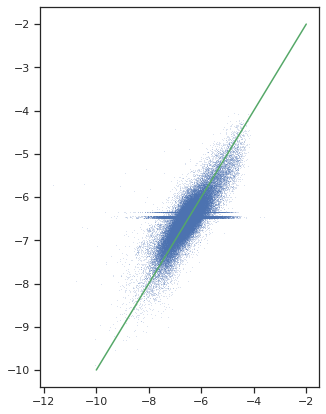

In [17]:
errors_vs_target(train_QM9_test_QM9, "RBF")

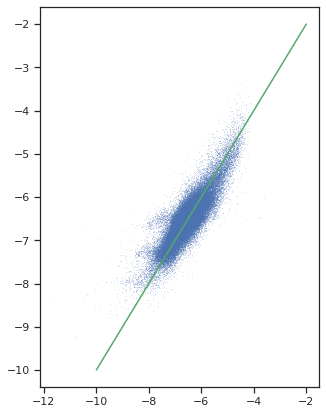

In [24]:
errors_vs_target(train_QM9_test_QM9, "DotProduct")

In [6]:
def eval_model(model, X_train, y_train, X_test, y_test, size):
    
    tstart = time.time()
    model.fit(X_train[:size], y_train[:size])
    fit_time = time.time() - tstart
    
    tstart = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - tstart
    
    MAE = np.mean(np.absolute(y_pred - y_test))
    
    return MAE, fit_time, predict_time
    

def data_efficiency_experiments(kernels, QM9_smiles):
    
    output_dict = {kernel[0]: {
        "size": [],
        "QM9_fit_time": [],
        "QM9_predict_time": [],
        "QM9_MAE": [],
    } for kernel in kernels}
    
    dataset_sizes = [10, 30, 100, 300, 1000, 3000, 10000]
    
    
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=N_JOBS, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    eval_strat = OPTEvaluationStrategy("homo", n_jobs=2, cache_files=[json_cache_location], 
                                     working_dir_path=dft_path, MM_program="rdkit")
    
    
    QM9_train_smiles, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
#     ChEMBL_train_smiles, ChEMBL_test_smiles = train_test_split(ChEMBL_smiles, test_size=50000)
    
    QM9_train_smiles = QM9_train_smiles[:10000]
#     ChEMBL_train_smiles = ChEMBL_train_smiles[:10000]
    
    QM9_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_train_smiles)]
    QM9_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(QM9_test_smiles)]
#     ChEMBL_train_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_train_smiles)]
#     ChEMBL_test_y = [eval_strat.eval_smi(smi) for smi in tqdm(ChEMBL_test_smiles)]
    
    for kernel in kernels:
        print(kernel[0])
        model = GaussianProcessRegressor(kernel=kernel[1], normalize_y=False, alpha=1e-1)

        if kernel[0] == "RBF":
            desc_builder = desc_builder_mbtr
        elif kernel[0] == "DotProduct":
            desc_builder = desc_builder_shingles

        QM9_train_X = desc_builder.fit_transform(QM9_train_smiles)[0]
        QM9_test_X = desc_builder.fit_transform(QM9_test_smiles)[0]
        
        for dataset_size in dataset_sizes:
            print(dataset_size)

            
            MAE_QM9, time_fit_QM9, time_predict_QM9 = eval_model(model, QM9_train_X, QM9_train_y, 
                                                                 QM9_test_X, QM9_test_y, 
                                                                 dataset_size)

            output_dict[kernel[0]]["size"].append(dataset_size)
            output_dict[kernel[0]]["QM9_fit_time"].append(time_fit_QM9)
            output_dict[kernel[0]]["QM9_predict_time"].append(time_predict_QM9)
            output_dict[kernel[0]]["QM9_MAE"].append(MAE_QM9)

            
    return output_dict
            

In [7]:
output_data_efficiency = data_efficiency_experiments(kernels, QM9_smiles)

NameError: name 'kernels' is not defined

In [22]:
def time_desc(QM9_smiles):
        
    desc_builder_shingles = ShinglesVectDesc(cache_location=None, count=True, vect_size=2000)
    desc_builder_mbtr = MBTRDesc(cache_location=None, n_jobs=1, cosine_angles_n=25, atomic_numbers_n=10, 
                                 inverse_distances_n=25, species=["C", "H", "O", "N", "F"], 
                                 MM_program="rdkit")
    
    _, QM9_test_smiles = train_test_split(QM9_smiles, test_size=50000)
    
    tstart = time.time()
    desc_builder_mbtr.fit_transform(QM9_test_smiles)
    time_mbtr_desc = time.time() - tstart
    
    tstart = time.time()
    desc_builder_shingles.fit_transform(QM9_test_smiles)
    time_shingles_desc = time.time() - tstart
    
    return time_mbtr_desc, time_shingles_desc

In [23]:
time_mbtr_desc, time_shingles_desc= time_desc(QM9_smiles)

  0%|          | 0/50000 [00:00<?, ?it/s]

MM program : obabel_mmff94
None
MM program : rdkit
species MBTR  : ['C', 'H', 'O', 'N', 'F']
atomic_numbers_n : 10
inverse_distances_n : 25
cosine_angles_n : 25


100%|██████████| 50000/50000 [02:12<00:00, 376.68it/s]


In [25]:
time_mbtr_desc/50

82.09350363731384

In [26]:
time_shingles_desc/50

2.655337414741516

In [1]:
import numpy as np
import pandas as pd
from os.path import join



def plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc):
    
    d = {"size": [], "Données": [], "predict_time": [], "desc_predict_time": [], "fit_time": [], "MAE": [], 
         "Modèle GPR": []} 
    
    k = "RBF"
    
    predict_time_denominateur = 50
    
    for k in ["RBF", "DotProduct"]:
        
        if k == "RBF":
            curr_time_desc = time_mbtr_desc
            name = "RBF, MBTR"
        elif k == "DotProduct":
            curr_time_desc = time_shingles_desc
            name = "DotProduct, shingles"
        
        d["size"].extend(output_data_efficiency[k]["size"])
        d["Données"].extend(np.full(len(output_data_efficiency[k]["size"],), "QM9"))
        d["Modèle GPR"].extend(np.full(len(output_data_efficiency[k]["size"],), name))
        d["fit_time"].extend(output_data_efficiency[k]["QM9_fit_time"])
        d["predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur)
        d["desc_predict_time"].extend(np.array(output_data_efficiency[k]["QM9_predict_time"])/predict_time_denominateur + curr_time_desc/predict_time_denominateur)
        d["MAE"].extend(output_data_efficiency[k]["QM9_MAE"])

        
    df = pd.DataFrame.from_dict(d)

   
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=df, x="size", y="MAE", hue="Modèle GPR", legend="brief")
    plt.ylabel("Erreur moyenne absolue (MAE)")
    plt.xlabel("Taille des données d'entraînement")
    plt.ylim(0, 0.5)
    
    plt.savefig(join(output_fig_path, "HOMO_MAE.png"), dpi=250)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6), sharex=True) #sharey=True)

    
#     handles, labels = ax1.get_legend_handles_labels()
#     ax1.legend(handles=handles[:2], labels=labels, title="Whatever else")
#     ax1.legend(handles=handles[2:4], labels=labels, title="Whatever else")
    

    sns.lineplot(x="size", y="fit_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax1, legend=False)
    sns.lineplot(x="size", y="predict_time", hue="Modèle GPR", data=df[df["Données"] == "QM9"], ax=ax2, legend=False)
    sns.lineplot(x="size", y="desc_predict_time", hue="Modèle GPR", data=df, ax=ax3)
    
    ax1.set_xlabel("Taille des données d'entraînement")
    ax1.set_ylabel("Temps (s)")
    ax1.set_yscale("log")
    ax1.set_ylim(1e-3, 1e4)
    ax1.set_title("Entraînement")
    
    ax2.set_xlabel("Taille des données d'entraînement")
    ax2.set_ylabel("")
    ax2.set_yscale("log")
    ax2.set_ylim(1e-3, 1e4)
    ax2.set_title("Prédiction (1000 mol.)")
    
    ax3.set_xlabel("Taille des données d'entraînement")
    ax3.set_ylabel("")
    ax3.set_yscale("log")
    ax3.set_ylim(1e-3, 1e4)
    ax3.set_title("Descripteurs + prédiction (1000 mol.)")
    ax3.legend(loc="lower right")
    
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.savefig(join(output_fig_path, "HOMO_times.png"), dpi=250)
    
    return df

In [2]:
plot_data_efficiency(output_data_efficiency, time_mbtr_desc, time_shingles_desc)

NameError: name 'output_data_efficiency' is not defined

In [81]:
output_data_efficiency

{'RBF': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.09586453437805176,
   0.0367436408996582,
   0.14430880546569824,
   0.9948077201843262,
   10.041736602783203,
   103.27187013626099,
   1162.460832118988],
  'QM9_predict_time': [0.7736244201660156,
   1.9272782802581787,
   5.914877414703369,
   18.27240777015686,
   69.77832365036011,
   210.74188423156738,
   699.5550472736359],
  'QM9_MAE': [0.45324956147634365,
   0.43737354619104146,
   0.4376647577946008,
   0.30030959815958186,
   0.2714248989246445,
   0.24842361601218854,
   0.22621561241750762]},
 'DotProduct': {'size': [10, 30, 100, 300, 1000, 3000, 10000],
  'QM9_fit_time': [0.01106882095336914,
   0.021631956100463867,
   0.05528998374938965,
   0.13118290901184082,
   1.4175353050231934,
   11.429084539413452,
   235.01068902015686],
  'QM9_predict_time': [0.13556671142578125,
   0.1778106689453125,
   0.28615236282348633,
   0.47157955169677734,
   1.210357904434204,
   3.3122518062591553,
  